In [1]:
!git clone https://github.com/NVlabs/stylegan

Cloning into 'stylegan'...
remote: Enumerating objects: 77, done.
remote: Total 77 (delta 0), reused 0 (delta 0), pack-reused 77
Unpacking objects: 100% (77/77), done.


In [0]:
import os
os.chdir('stylegan')

In [3]:
import time
import re
import bisect
from collections import OrderedDict
import numpy as np
import tensorflow as tf
import scipy.ndimage
import scipy.misc
import pickle
import dnnlib
import dnnlib.tflib as tflib
from PIL import Image
from IPython.display import display

W0828 23:46:56.914453 139852722513792 deprecation_wrapper.py:119] From /content/stylegan/dnnlib/tflib/tfutil.py:34: The name tf.Dimension is deprecated. Please use tf.compat.v1.Dimension instead.

W0828 23:46:56.915941 139852722513792 deprecation_wrapper.py:119] From /content/stylegan/dnnlib/tflib/tfutil.py:74: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0828 23:46:56.916904 139852722513792 deprecation_wrapper.py:119] From /content/stylegan/dnnlib/tflib/tfutil.py:128: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [0]:
sess = tf.InteractiveSession()

In [5]:
url = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ' # karras2019stylegan-ffhq-1024x1024.pkl
with dnnlib.util.open_url(url, '.') as f:
      _G, _D, Gs = pickle.load(f)

W0828 23:47:01.073774 139852722513792 deprecation_wrapper.py:119] From /content/stylegan/dnnlib/tflib/tfutil.py:124: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0828 23:47:01.084098 139852722513792 deprecation_wrapper.py:119] From /content/stylegan/dnnlib/tflib/network.py:142: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0828 23:47:05.489010 139852722513792 deprecation.py:323] From <string>:364: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)


In [0]:
L = 5

In [0]:
src_latents = np.random.randn(L, *Gs.input_shape[1:])
dst_latents = np.random.randn(L, *Gs.input_shape[1:])

In [0]:
src_dlatents = Gs.components.mapping.run(src_latents, None) # [seed, layer, component]
dst_dlatents = Gs.components.mapping.run(dst_latents, None) # [seed, layer, component]

In [10]:
for k,v  in Gs.components.mapping._run_cache.items():
    print(k)
    print(v[0])
    print(v[1])

[('assume_frozen', False), ('dynamic_kwargs', []), ('input_transform', None), ('num_gpus', 1), ('output_transform', None)]
[<tf.Tensor 'G_mapping_1/_Run/latents_in:0' shape=<unknown> dtype=float32>, <tf.Tensor 'G_mapping_1/_Run/labels_in:0' shape=<unknown> dtype=float32>]
[<tf.Tensor 'G_mapping_1/_Run/concat:0' shape=(?, 18, 512) dtype=float32>]


In [11]:
v[1][0].op.inputs[0]

<tf.Tensor 'G_mapping_1/_Run/G_mapping/dlatents_out:0' shape=(?, 18, 512) dtype=float32>

In [0]:
synthesis_kwargs = dict(output_transform=fmt)
src_images = Gs.components.synthesis.run(src_dlatents, randomize_noise=False, **synthesis_kwargs)
dst_images = Gs.components.synthesis.run(dst_dlatents, randomize_noise=False, **synthesis_kwargs)

In [13]:
for k,v  in Gs.components.synthesis._run_cache.items():
    print(k)
    print(v[0])
    print(v[1])

[('assume_frozen', False), ('dynamic_kwargs', [('randomize_noise', False)]), ('input_transform', None), ('num_gpus', 1), ('output_transform', [('func', 'dnnlib.tflib.tfutil.convert_images_to_uint8'), ('nchw_to_nhwc', True)])]
[<tf.Tensor 'G_synthesis_1/_Run/dlatents_in:0' shape=<unknown> dtype=float32>]
[<tf.Tensor 'G_synthesis_1/_Run/concat:0' shape=(?, 1024, 1024, 3) dtype=uint8>]


In [14]:
v[1][0].op.inputs[0]

<tf.Tensor 'G_synthesis_1/_Run/saturate_cast:0' shape=(?, 1024, 1024, 3) dtype=uint8>

In [15]:
src_dlatents.shape

(5, 18, 512)

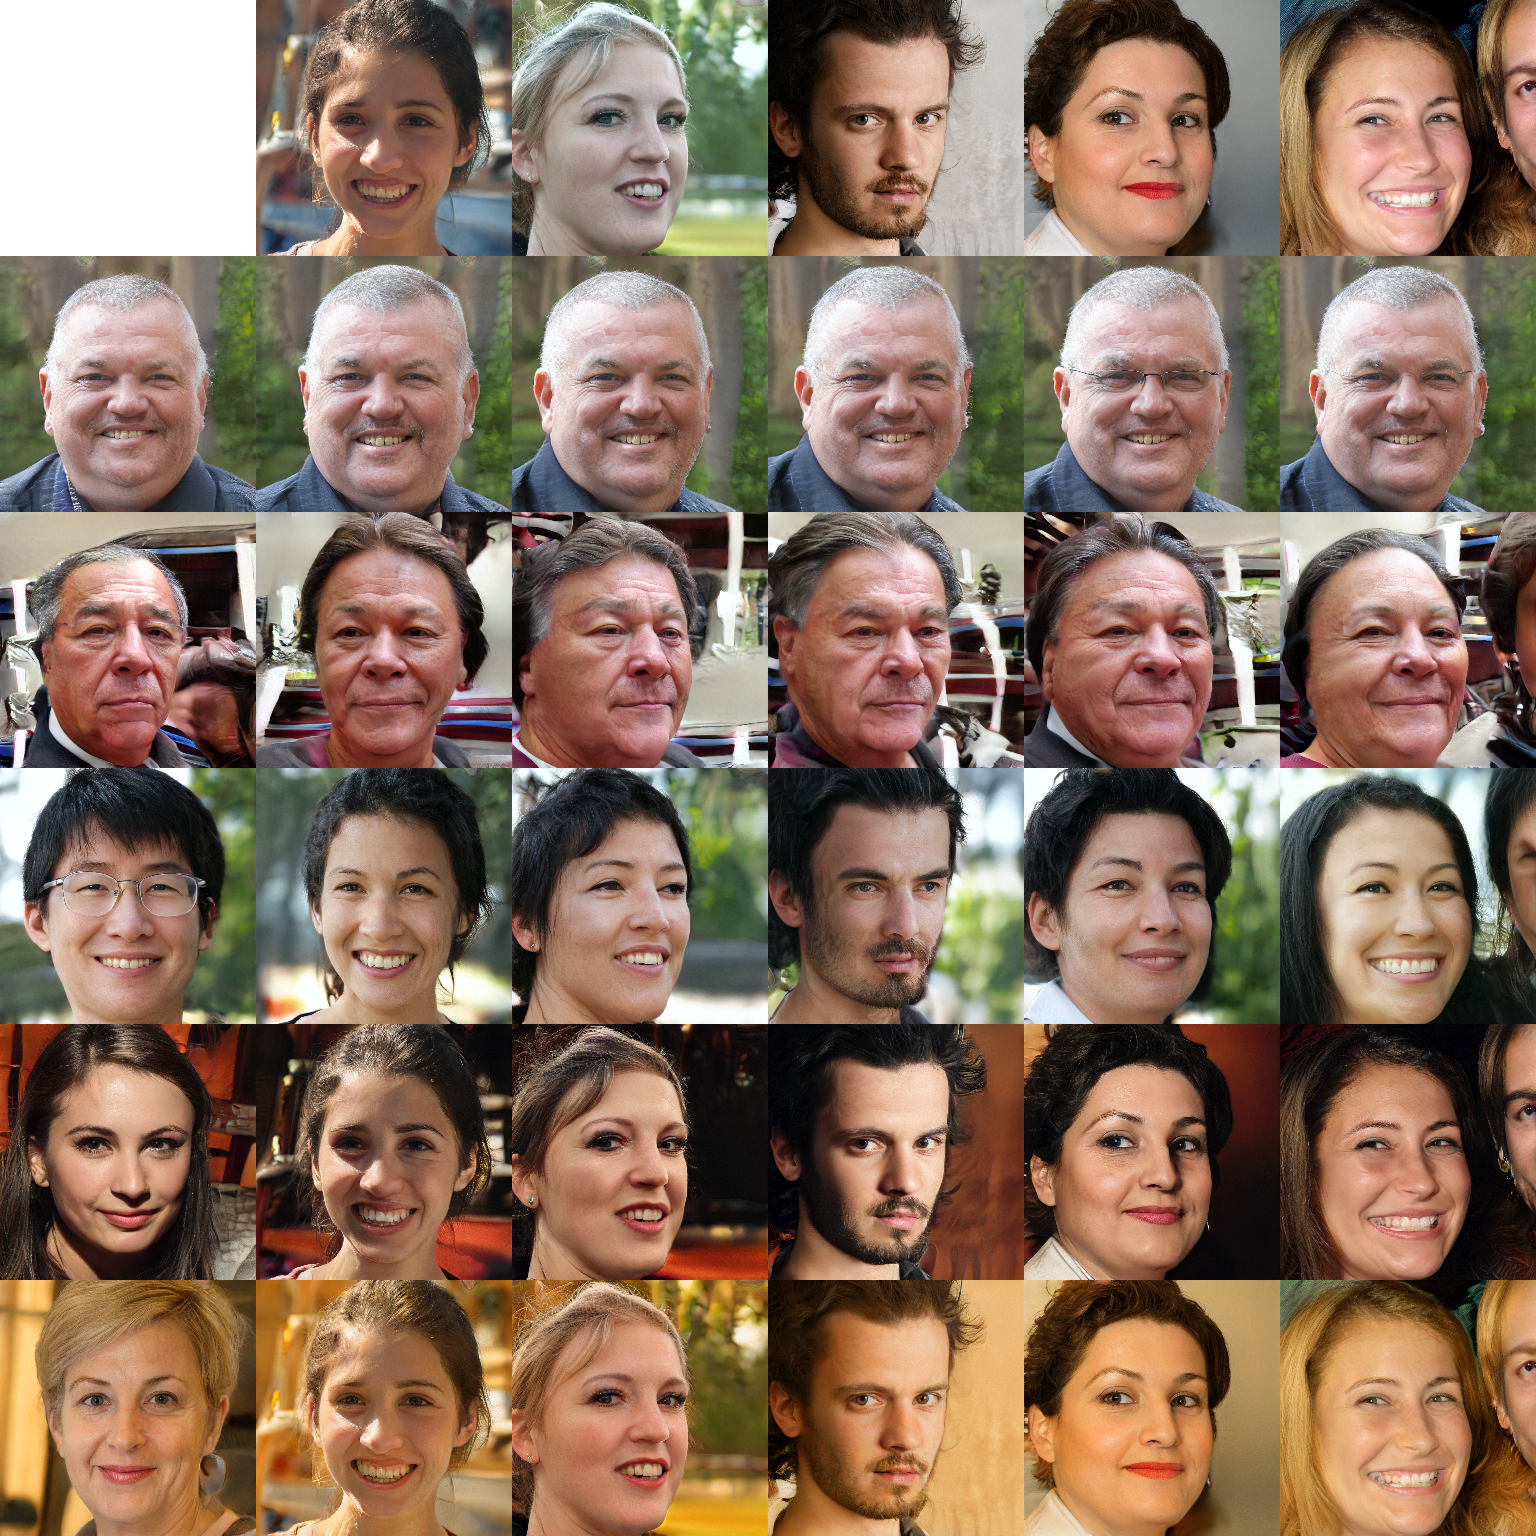

In [17]:
w,h=256,256
style_ranges=[range(0,1), range(0,3), range(0,5), range(0,8), range(0,11)]
canvas = Image.new('RGB', (w * (L + 1), h * (L + 1)) , 'white')
for col, src_image in enumerate(list(src_images)):
    canvas.paste(Image.fromarray(src_image, 'RGB').resize((w,h)), ((col + 1) * w, 0))
for row, dst_image in enumerate(list(dst_images)):
        canvas.paste(Image.fromarray(dst_image, 'RGB').resize((w,h)), (0, (row + 1) * h))
        row_dlatents = np.stack([dst_dlatents[row]] * L)
        row_dlatents[:, style_ranges[row]] = src_dlatents[:, style_ranges[row]]
        row_images = Gs.components.synthesis.run(row_dlatents, randomize_noise=False, **synthesis_kwargs)
        for col, image in enumerate(list(row_images)):
            canvas.paste(Image.fromarray(image, 'RGB').resize((w,h)), ((col + 1) * w, (row + 1) * h))
display(canvas)